# Mining COVID-19 Kaggle competition scientific papers to build an understanding of viruses
## Part 1. Acquiring and exploring the data

**Author**: Tom Drabas

# Imports

In [1]:
import urllib, os, sys
from os.path import isfile
from tqdm import tqdm

import cudf
import pandas as pd
import json

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Get the data
The part below downloads the cord-19 corupus published on 2020-08-24.

In [2]:
date = '2020-08-24'
url = f'https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases/cord-19_{date}.tar.gz'
data_dir = 'data'
tar_file = data_dir + '/cord-19.tar.gz'
extract = False

if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    
if not os.path.exists(tar_file):
    with open(tar_file, 'wb') as file:
        with urllib.request.urlopen(url) as resp:
            length = int(resp.getheader('content-length'))
            blocksize = max(4096, length // 100)

            with tqdm(total=length, file=sys.stdout) as pbar:
                while True:
                    buff = resp.read(blocksize)
                    if not buff:
                        break
                    file.write(buff)
                    pbar.update(len(buff))
                    
if extract:
    import tarfile

    tf = tarfile.open(tar_file)
    tf.extractall(path=data_dir)
    
    doc_parses = tarfile.open(f'{data_dir}/{date}/document_parses.tar.gz')
    doc_parses.extractall(f'{data_dir}/{date}')

## Read the metadata

In [3]:
metadata = cudf.read_csv(f'{data_dir}/{date}/metadata.csv')
metadata.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,<NA>,<NA>,<NA>,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,<NA>
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,<NA>,<NA>,<NA>,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,<NA>
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,<NA>,<NA>,<NA>,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,<NA>
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,<NA>,<NA>,<NA>,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,<NA>
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,<NA>,<NA>,<NA>,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,<NA>


In [4]:
metadata.columns

Index(['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id',
       'license', 'abstract', 'publish_time', 'authors', 'journal', 'mag_id',
       'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files',
       'url', 's2_id'],
      dtype='object')

# Blazing SQL

In [5]:
from blazingsql import BlazingContext

# Start up BlazingSQL
bc = BlazingContext()

# Create table from CSV
bc.create_table('metadata', metadata)

ModuleNotFoundError: No module named 'blazingsql'

## Data exploration

### Article count

In [6]:
print(f'Total number of articles: {len(metadata):,}.')

Total number of articles: 233,539.


In [7]:
bc.sql('SELECT COUNT(*) FROM metadata')

,count(*)
0,233539


### Source

In [8]:
%%time
(
    metadata
    .groupby(by='source_x')
    .agg({'cord_uid': 'count'})
    .sort_values(by='cord_uid', ascending=False)
    .head(10)
)

CPU times: user 93.3 ms, sys: 5.97 ms, total: 99.3 ms
Wall time: 71 ms


,cord_uid
source_x,
WHO,64492
Medline,58096
Medline; PMC,35265
PMC,32252
Elsevier; Medline; PMC,23091
Elsevier; PMC,6059
MedRxiv,5890
ArXiv,2923
BioRxiv,1713


In [9]:
%%time
bc.sql('''
    SELECT source_x
        , COUNT(*) AS cnt 
    FROM metadata 
    GROUP BY source_x 
    ORDER BY cnt DESC 
    LIMIT 10
''')

CPU times: user 247 ms, sys: 4.58 ms, total: 251 ms
Wall time: 96.7 ms


,source_x,cnt
0,WHO,64492
1,Medline,58096
2,Medline; PMC,35265
3,PMC,32252
4,Elsevier; Medline; PMC,23091
5,Elsevier; PMC,6059
6,MedRxiv,5890
7,ArXiv,2923
8,BioRxiv,1713
9,Medline; PMC; WHO,1119


## Journals

In [10]:
metadata.groupby(by='journal').agg({'cord_uid': 'count'}).sort_values(by='cord_uid', ascending=False).head(10)

,cord_uid
journal,
bioRxiv,2362
BMJ,2334
PLoS One,2114
Journal of virology,1665
Lancet,1305
Nature,1130
J Med Virol,967
Virology,948
Emerg Infect Dis,931


In [11]:
bc.sql('''
    SELECT journal
        , COUNT(*) AS CNT
    FROM metadata
    WHERE journal IS NOT NULL
    GROUP BY journal
    ORDER BY CNT DESC
    LIMIT 10
''')

,journal,CNT
0,bioRxiv,2362
1,BMJ,2334
2,PLoS One,2114
3,Journal of virology,1665
4,Lancet,1305
5,Nature,1130
6,J Med Virol,967
7,Virology,948
8,Emerg Infect Dis,931
9,Surgical endoscopy,926


### Publication years

<AxesSubplot:xlabel='year_published'>

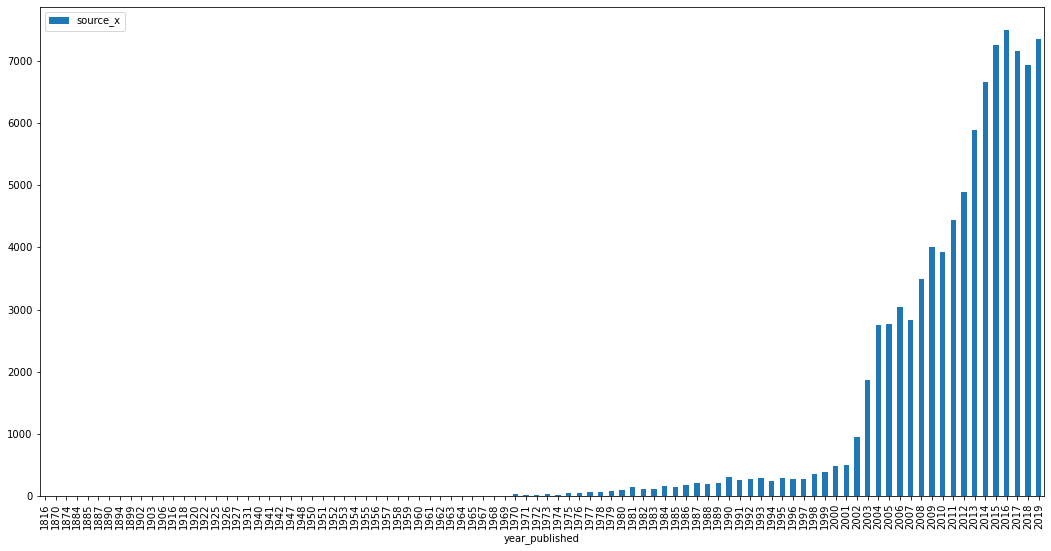

In [6]:
metadata['year_published'] = metadata.publish_time.str.extract('([0-9\.\-]{4})')[0].astype('int16')

(
    metadata
    .query('year_published < 2020')
    .groupby(by='year_published')
    .agg({'source_x': 'count'})
    .to_pandas()
    .plot(kind='bar', figsize=(18,9))
)

<AxesSubplot:xlabel='year_published'>

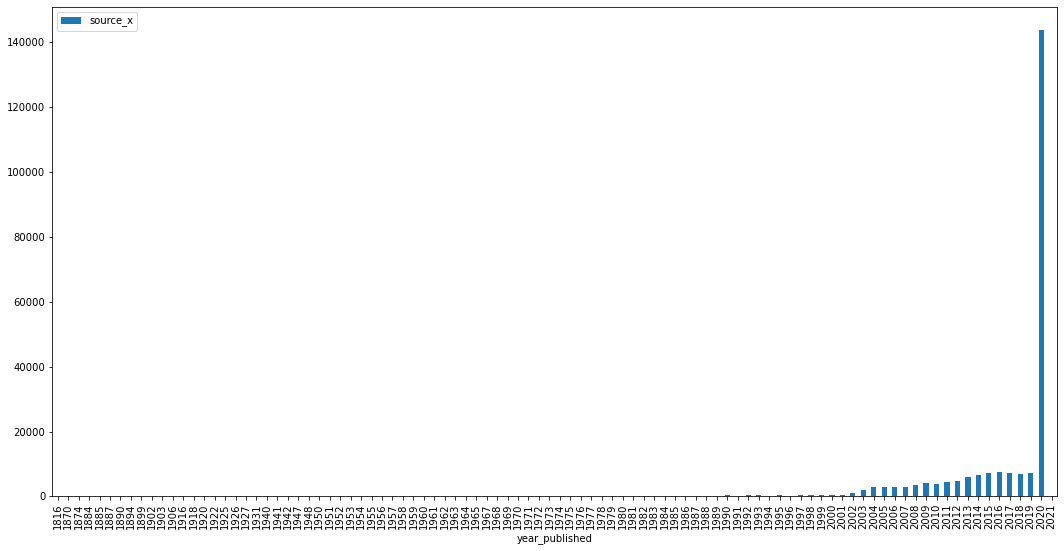

In [7]:
(
    metadata
    .groupby(by='year_published')
    .agg({'source_x': 'count'})
    .to_pandas()
    .plot(kind='bar', figsize=(18,9))
)

In [14]:
bc.create_table('metadata', bc.sql('''
    SELECT *
        , CAST(SUBSTRING(publish_time, 1, 4) AS INT) AS year_published
    FROM metadata
'''))

<AxesSubplot:xlabel='year_published'>

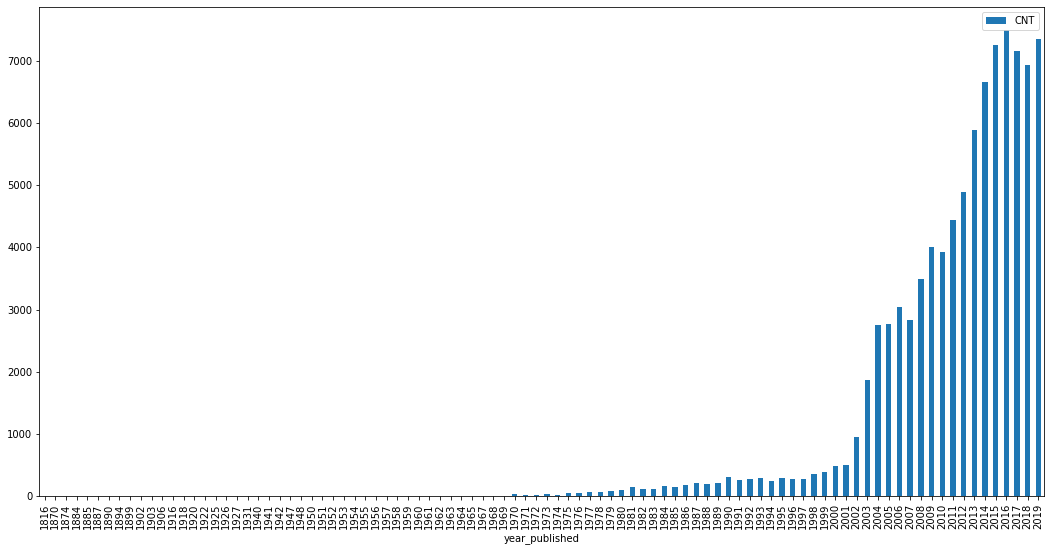

In [15]:
(
    bc.sql('''
        SELECT year_published
            , COUNT(*) AS CNT
        FROM metadata
        WHERE year_published < 2020
        GROUP BY year_published
        ORDER BY year_published ASC
    ''')
    .to_pandas()
    .set_index('year_published')
    .plot(kind='bar', figsize=(18,9))
)

## Coronavirus research accellerates in 2020

<AxesSubplot:ylabel='prior_2020'>

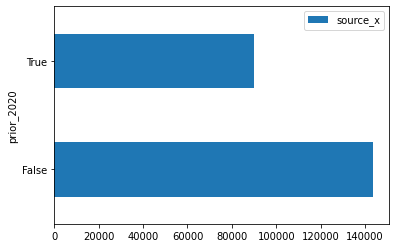

In [16]:
metadata['prior_2020'] = metadata['year_published'] < 2020
metadata.groupby(by='prior_2020').agg({'source_x': 'count'}).to_pandas().plot(kind='barh')

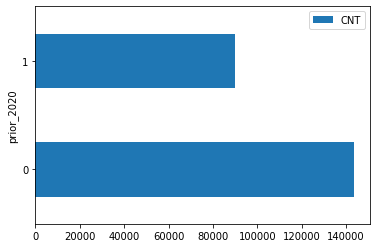

In [17]:
bc.create_table('metadata', bc.sql('''
    SELECT *
        , CASE WHEN year_published < 2020 THEN 1 ELSE 0 END prior_2020
    FROM metadata
'''))

(
    bc.sql('''
        SELECT prior_2020
            , COUNT(*) AS CNT
        FROM metadata
        GROUP BY prior_2020
        ORDER BY prior_2020
    ''')
    .to_pandas()
    .set_index('prior_2020')
    .plot(kind='barh')
)


plt.savefig('prior_2020.png', dpi=300)

# Missing values

In [18]:
cols = list(metadata.columns)[2:-3]

query_missing = 'SELECT '
query_missing += '\n    ,'.join([f'CASE WHEN {col} IS NULL THEN 1 ELSE 0 END AS {col}_miss' for col in cols])
query_missing += '\nFROM metadata'

query_unions = '\nUNION ALL \n    '.join([f"SELECT '{col}_miss' AS miss_flag, {col}_miss AS FLAG, COUNT(*) AS CNT FROM missing_flags GROUP BY {col}_miss" for col in cols])

bc.create_table('missing_flags', bc.sql(query_missing))
bc.create_table('missing_summary', bc.sql(query_unions))

row_cnt = float(len(metadata))

bc.sql(f'''
    SELECT *
        , CNT / {row_cnt} * 100.0 AS MISS_PCNT
    FROM missing_summary 
    WHERE FLAG = 1
    ORDER BY MISS_PCNT DESC
''')

,miss_flag,FLAG,CNT,MISS_PCNT
0,mag_id_miss,1,233539,100.000000
1,arxiv_id_miss,1,230456,98.679878
2,who_covidence_id_miss,1,168845,72.298417
3,pmc_json_files_miss,1,161714,69.244966
4,pdf_json_files_miss,1,139595,59.773742
5,pmcid_miss,1,134679,57.668741
6,pubmed_id_miss,1,100734,43.133695
7,doi_miss,1,79106,33.872715
8,abstract_miss,1,68281,29.237515
9,url_miss,1,64433,27.589824


In [27]:
print(query_missing)

SELECT CASE WHEN source_x IS NULL THEN 1 ELSE 0 END AS source_x_miss
    ,CASE WHEN title IS NULL THEN 1 ELSE 0 END AS title_miss
    ,CASE WHEN doi IS NULL THEN 1 ELSE 0 END AS doi_miss
    ,CASE WHEN pmcid IS NULL THEN 1 ELSE 0 END AS pmcid_miss
    ,CASE WHEN pubmed_id IS NULL THEN 1 ELSE 0 END AS pubmed_id_miss
    ,CASE WHEN license IS NULL THEN 1 ELSE 0 END AS license_miss
    ,CASE WHEN abstract IS NULL THEN 1 ELSE 0 END AS abstract_miss
    ,CASE WHEN publish_time IS NULL THEN 1 ELSE 0 END AS publish_time_miss
    ,CASE WHEN authors IS NULL THEN 1 ELSE 0 END AS authors_miss
    ,CASE WHEN journal IS NULL THEN 1 ELSE 0 END AS journal_miss
    ,CASE WHEN mag_id IS NULL THEN 1 ELSE 0 END AS mag_id_miss
    ,CASE WHEN who_covidence_id IS NULL THEN 1 ELSE 0 END AS who_covidence_id_miss
    ,CASE WHEN arxiv_id IS NULL THEN 1 ELSE 0 END AS arxiv_id_miss
    ,CASE WHEN pdf_json_files IS NULL THEN 1 ELSE 0 END AS pdf_json_files_miss
    ,CASE WHEN pmc_json_files IS NULL THEN 1 ELSE 0 EN

In [28]:
print(query_unions)

SELECT 'source_x_miss' AS miss_flag, source_x_miss AS FLAG, COUNT(*) AS CNT FROM missing_flags GROUP BY source_x_miss
UNION ALL 
    SELECT 'title_miss' AS miss_flag, title_miss AS FLAG, COUNT(*) AS CNT FROM missing_flags GROUP BY title_miss
UNION ALL 
    SELECT 'doi_miss' AS miss_flag, doi_miss AS FLAG, COUNT(*) AS CNT FROM missing_flags GROUP BY doi_miss
UNION ALL 
    SELECT 'pmcid_miss' AS miss_flag, pmcid_miss AS FLAG, COUNT(*) AS CNT FROM missing_flags GROUP BY pmcid_miss
UNION ALL 
    SELECT 'pubmed_id_miss' AS miss_flag, pubmed_id_miss AS FLAG, COUNT(*) AS CNT FROM missing_flags GROUP BY pubmed_id_miss
UNION ALL 
    SELECT 'license_miss' AS miss_flag, license_miss AS FLAG, COUNT(*) AS CNT FROM missing_flags GROUP BY license_miss
UNION ALL 
    SELECT 'abstract_miss' AS miss_flag, abstract_miss AS FLAG, COUNT(*) AS CNT FROM missing_flags GROUP BY abstract_miss
UNION ALL 
    SELECT 'publish_time_miss' AS miss_flag, publish_time_miss AS FLAG, COUNT(*) AS CNT FROM missing_flags

## Remove observations with missing pdf parsed json

In [20]:
bc.create_table('metadata_no_missing', bc.sql('SELECT * FROM metadata WHERE pdf_json_files IS NOT NULL'))
bc.sql('SELECT COUNT(*) FROM metadata_no_missing')

,count(*)
0,93944


In [21]:
query_missing = 'SELECT '
query_missing += '\n    ,'.join([f'CASE WHEN {col} IS NULL THEN 1 ELSE 0 END AS {col}_miss' for col in cols])
query_missing += '\nFROM metadata_no_missing'

query_unions = '\nUNION ALL \n    '.join([f"SELECT '{col}_miss' AS miss_flag, {col}_miss AS FLAG, COUNT(*) AS CNT FROM missing_flags GROUP BY {col}_miss" for col in cols])

bc.create_table('missing_flags', bc.sql(query_missing))
bc.create_table('missing_summary', bc.sql(query_unions))

row_cnt = float(len(metadata))

bc.sql(f'''
    SELECT *
        , CNT / {row_cnt} * 100.0 AS MISS_PCNT
    FROM missing_summary 
    WHERE FLAG = 1
    ORDER BY MISS_PCNT DESC
''')

,miss_flag,FLAG,CNT,MISS_PCNT
0,who_covidence_id_miss,1,93944,40.226258
1,mag_id_miss,1,93944,40.226258
2,arxiv_id_miss,1,91527,39.191313
3,pubmed_id_miss,1,26161,11.201983
4,pmc_json_files_miss,1,25859,11.072669
5,abstract_miss,1,16928,7.248468
6,pmcid_miss,1,9355,4.005755
7,journal_miss,1,8576,3.672192
8,doi_miss,1,2605,1.115445
9,authors_miss,1,1513,0.647858


# Duplicates

In [22]:
cols_to_check_for_dupes = ['url', 'title', 'doi', 'abstract', 'pdf_json_files', 'pmc_json_files']

col = cols_to_check_for_dupes[5]

select_pattern = '{c}_DIST, {c}_MISS, {c}_DIST + {c}_MISS AS {c}_TTL, CNT - {c}_DIST - {c}_MISS AS {c}_DUPES'
count_pattern  = 'COUNT(DISTINCT {c}) AS {c}_DIST, SUM(CASE WHEN {c} IS NULL THEN 1 ELSE 0 END) AS {c}_MISS'

query = f'SELECT CNT\n    , '
query += '\n    , '.join([select_pattern.format(c=c) for c in cols_to_check_for_dupes])
query += '\nFROM (\n    SELECT COUNT(*) AS CNT, '
query += '\n        ,'.join([count_pattern.format(c=c) for c in cols_to_check_for_dupes])
query += '\n    FROM metadata_no_missing\n) AS A'

bc.sql(query)

,CNT,url_DIST,url_MISS,url_TTL,url_DUPES,title_DIST,title_MISS,title_TTL,title_DUPES,doi_DIST,doi_MISS,doi_TTL,doi_DUPES,abstract_DIST,abstract_MISS,abstract_TTL,abstract_DUPES,pdf_json_files_DIST,pdf_json_files_MISS,pdf_json_files_TTL,pdf_json_files_DUPES,pmc_json_files_DIST,pmc_json_files_MISS,pmc_json_files_TTL,pmc_json_files_DUPES
0,93944,93944,0,93944,0,92724,1,92725,1219,91338,2605,93943,1,76734,16928,93662,282,93938,0,93938,6,68085,25859,93944,0


In [23]:
bc.create_table('duplicates', bc.sql(query))

In [28]:
import csv

query_dupes = 'SELECT '
query_dupes += ','.join(f'{c}_DUPES' for c in cols_to_check_for_dupes)
query_dupes += ' FROM duplicates'
bc.sql(query_dupes)

,url_DUPES,title_DUPES,doi_DUPES,abstract_DUPES,pdf_json_files_DUPES,pmc_json_files_DUPES
0,0,1219,1,282,6,0


In [32]:
print(query)

SELECT CNT
    , url_DIST, url_MISS, url_DIST + url_MISS AS url_TTL, CNT - url_DIST - url_MISS AS url_DUPES
    , title_DIST, title_MISS, title_DIST + title_MISS AS title_TTL, CNT - title_DIST - title_MISS AS title_DUPES
    , doi_DIST, doi_MISS, doi_DIST + doi_MISS AS doi_TTL, CNT - doi_DIST - doi_MISS AS doi_DUPES
    , abstract_DIST, abstract_MISS, abstract_DIST + abstract_MISS AS abstract_TTL, CNT - abstract_DIST - abstract_MISS AS abstract_DUPES
    , pdf_json_files_DIST, pdf_json_files_MISS, pdf_json_files_DIST + pdf_json_files_MISS AS pdf_json_files_TTL, CNT - pdf_json_files_DIST - pdf_json_files_MISS AS pdf_json_files_DUPES
    , pmc_json_files_DIST, pmc_json_files_MISS, pmc_json_files_DIST + pmc_json_files_MISS AS pmc_json_files_TTL, CNT - pmc_json_files_DIST - pmc_json_files_MISS AS pmc_json_files_DUPES
FROM (
    SELECT COUNT(*) AS CNT, COUNT(DISTINCT url) AS url_DIST, SUM(CASE WHEN url IS NULL THEN 1 ELSE 0 END) AS url_MISS
        ,COUNT(DISTINCT title) AS title_DIST, SUM(

In [33]:
bc.sql('SELECT pdf_json_files FROM metadata_no_missing GROUP BY pdf_json_files HAVING COUNT(*) > 1')

,pdf_json_files
0,document_parses/pdf_json/f536fbcee55b3ed0f63a7...
1,document_parses/pdf_json/0ed3c6a5559cd73307184...
2,document_parses/pdf_json/d1dde1df11f93e8eae0d0...
3,document_parses/pdf_json/36e2047d1674c3095617f...
4,document_parses/pdf_json/ec7d3038b8912a9fc92f4...


We only want to keep one record with the same `pdf_json_files`. Let's check if the other fields are duplicates as well

In [30]:
bc.sql('''
    SELECT A.*
    FROM metadata_no_missing AS A
    INNER JOIN (
        SELECT pdf_json_files FROM metadata_no_missing GROUP BY pdf_json_files HAVING COUNT(*) > 1
    ) AS B
    ON A.pdf_json_files = B.pdf_json_files
    ORDER BY A.pdf_json_files
''')

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,year_published,prior_2020
0,p92y5er2,0ed3c6a5559cd73307184f51fc53ccc76da559bc,Elsevier; Medline; PMC,Novel coronavirus disease (Covid-19): The firs...,10.1016/j.jinf.2020.02.020,PMC7127394,32119884,els-covid,<NA>,2020-05-31,"Lillie, Patrick J.; Samson, Anda; Li, Ang; Ada...",Journal of Infection,<NA>,<NA>,<NA>,document_parses/pdf_json/0ed3c6a5559cd73307184...,document_parses/pmc_json/PMC7127394.xml.json,https://api.elsevier.com/content/article/pii/S...,211832079.0,2020,0
1,plwyjhl8,0ed3c6a5559cd73307184f51fc53ccc76da559bc,Elsevier; Medline; PMC,Simulating and forecasting the cumulative conf...,10.1016/j.jinf.2020.02.019,PMC7127674,32112887,no-cc,• Cumulative confirmed cases in China were wel...,2020-02-26,"Fu, Xinmiao; Ying, Qi; Zeng, Tieyong; Long, Ta...",J Infect,<NA>,<NA>,<NA>,document_parses/pdf_json/0ed3c6a5559cd73307184...,document_parses/pmc_json/PMC7127674.xml.json,https://api.elsevier.com/content/article/pii/S...,211573526.0,2020,0
2,8xx1xm2d,0ed3c6a5559cd73307184f51fc53ccc76da559bc,Elsevier; Medline; PMC; WHO,Chinese medical personnel against the 2019-nCoV,10.1016/j.jinf.2020.02.011,PMC7126162,32092388,els-covid,<NA>,2020-05-31,"Feng, Zhan-hui; Cheng, Yong-ran; Chen, Juan; Y...",Journal of Infection,<NA>,<NA>,<NA>,document_parses/pdf_json/0ed3c6a5559cd73307184...,document_parses/pmc_json/PMC7126162.xml.json,https://www.sciencedirect.com/science/article/...,211474840.0,2020,0
3,zhw8vh3e,36e2047d1674c3095617f3eb97f9f61e48989dfe,PMC,Artificial Intelligence (AI) applications for ...,10.1016/j.dsx.2020.04.012,PMC7195043,32305024,no-cc,BACKGROUND AND AIMS: Healthcare delivery requi...,2020-04-14,"Vaishya, Raju; Javaid, Mohd; Khan, Ibrahim Hal...",Diabetes Metab Syndr,<NA>,<NA>,<NA>,document_parses/pdf_json/36e2047d1674c3095617f...,document_parses/pmc_json/PMC7195043.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,<NA>,2020,0
4,zhw8vh3e,36e2047d1674c3095617f3eb97f9f61e48989dfe,Elsevier,Artificial Intelligence (AI) applications for ...,10.1016/j.dsx.2020.04.012,<NA>,<NA>,els-covid,Abstract Background and aims Healthcare delive...,2020-08-31,"Vaishya, Raju; Javaid, Mohd; Khan, Ibrahim Hal...",Diabetes & Metabolic Syndrome: Clinical Resear...,<NA>,<NA>,<NA>,document_parses/pdf_json/36e2047d1674c3095617f...,<NA>,https://api.elsevier.com/content/article/pii/S...,215819243.0,2020,0
5,dtnuet6c,d1dde1df11f93e8eae0d0b467cd0455afdc5b98c,ArXiv,Knowledge synthesis from 100 million biomedica...,<NA>,<NA>,<NA>,arxiv,The COVID-19 pandemic demands assimilation of ...,2020-03-28,"Venkatakrishnan, AJ; Puranik, Arjun; Anand, Ak...",<NA>,<NA>,<NA>,2003.12773,document_parses/pdf_json/d1dde1df11f93e8eae0d0...,<NA>,https://arxiv.org/pdf/2003.12773v1.pdf,214714136.0,2020,0
6,j7t9nebs,d1dde1df11f93e8eae0d0b467cd0455afdc5b98c,BioRxiv,Knowledge synthesis from 100 million biomedica...,10.1101/2020.03.24.005702,<NA>,<NA>,biorxiv,The COVID-19 pandemic demands assimilation of ...,2020-03-29,"Venkatakrishnan, AJ; Puranik, Arjun; Anand, Ak...",bioRxiv,<NA>,<NA>,<NA>,document_parses/pdf_json/d1dde1df11f93e8eae0d0...,<NA>,https://doi.org/10.1101/2020.03.24.005702,214714136.0,2020,0
7,hqbstgg7,ec7d3038b8912a9fc92f4d02a2c30d566d4d0a93,ArXiv,Modern Hopfield Networks and Attention for Imm...,<NA>,<NA>,<NA>,arxiv,A central mechanism in machine learning is to ...,2020-07-16,"Widrich, Michael; Schafl, Bernhard; Ramsauer, ...",<NA>,<NA>,<NA>,2007.13505,document_parses/pdf_json/ec7d3038b8912a9fc92f4...,<NA>,https://arxiv.org/pdf/2007.13505v1.pdf,220793544.0,2020,0
8,4stnx8dw,ec7d3038b8912a9fc92f4d02a2c30d566d4d0a93,BioRxiv,Modern Hopfield Networks and Attention for Imm...,10.1101/2020.04.12.038158,<NA>,<NA>,biorxiv,A central mechanism in machine learning is to ...,2020-08-17,"Widrich, Michael; Schäfl, Bernhard; Pavlović, ...",bioRxiv,<NA>,<NA>,<NA>,document_parses/pdf_json/ec7d3038b8912a9fc9

The top 3 articles seem simply mislabled as the pmc_json_files point to different xml files and they seem to be 3 different articles. The remaining seem to be duplicated entries. Since the number is low we remove them all

In [32]:
metadata_json_clean = bc.sql('''
    SELECT A.*
    FROM metadata_no_missing AS A
    INNER JOIN (
        SELECT pdf_json_files FROM metadata_no_missing GROUP BY pdf_json_files HAVING COUNT(*) = 1
    ) AS B
    ON A.pdf_json_files = B.pdf_json_files
    ORDER BY A.pdf_json_files
''')
                             
bc.create_table('metadata_json_clean', metadata_json_clean)

## Title duplicates

In [36]:
bc.sql('''SELECT A.title
        , A.doi
        , A.abstract
        , A.authors
        , A.journal
        , A.year_published
    FROM metadata_json_clean AS A
    INNER JOIN (
        SELECT title FROM metadata_json_clean GROUP BY title HAVING COUNT(*) > 1
    ) AS B
    ON A.title = B.title
    ORDER BY A.title
    LIMIT 10''')

,title,doi,abstract,authors,journal,year_published
0,(13)C Chemical Shifts in Proteins: A Rich Sour...,10.1007/978-3-319-95843-9_20,Despite the formidable progress in Nuclear Mag...,"Vila, Jorge A.; Arnautova, Yelena A.",Computational Methods to Study the Structure a...,2018
1,(13)C Chemical Shifts in Proteins: A Rich Sour...,10.1007/978-3-642-28554-7_19,Despite the formidable progress in Nuclear Mag...,"Vila, Jorge A.; Arnautova, Yelena A.",Computational Methods to Study the Structure a...,2014
2,1 Tropical Lung Diseases,10.1016/b978-0-323-55512-8.00001-6,Abstract Lung disease is common in the tropics...,"Papanikolaou, Ilias C.; Tsenempi, Xenia A.",Hunter's Tropical Medicine and Emerging Infect...,2020
3,1 Tropical Lung Diseases,10.1016/b978-1-4160-4390-4.00001-1,<NA>,"Papanikolaou, Ilias C; Sharma, Om P",Hunter's Tropical Medicine and Emerging Infect...,2013
4,10 Adaptive Measures for Public Places to face...,10.1111/ciso.12335,<NA>,"Cheshmehzangi, Ali",City Soc (Wash),2020
5,10 Adaptive Measures for Public Places to face...,10.1111/ciso.12282,<NA>,"Cheshmehzangi, Ali",City Soc (Wash),2020
6,10 Infectious Disease Genomics,10.1016/b978-0-12-384890-1.00010-8,"During the past 20 years, the history and deve...","Liu, Yu-Tsueng",Genetics and Evolution of Infectious Disease,2011
7,10 Infectious Disease Genomics,10.1016/b978-0-12-799942-5.00010-x,Abstract The history and development of infect...,"Liu, Y.-T.",Genetics and Evolution of Infectious Diseases,2017
8,21st ESICM Annual Congress,10.1007/s00134-008-1241-2,<NA>,<NA>,Intensive Care Med,2008
9,21st ESICM Annual Congress,10.1007/s00134-008-1240-3,<NA>,<NA>,Intensive Care Med,2008


In [37]:
metadata_title_clean = metadata_json_clean.drop_duplicates(subset=['title'])

In [38]:
bc.create_table('metadata_title_clean', metadata_title_clean)
bc.sql('SELECT title FROM metadata_title_clean GROUP BY title HAVING COUNT(*) > 1')

,title


# Missing JSON files

In [40]:
from os import listdir
from os.path import isfile, join

pdf_json = f'{data_dir}/{date}/document_parses/pdf_json'
files = ['document_parses/pdf_json/' + f for f in listdir(pdf_json) if isfile(join(pdf_json, f))]
bc.create_table('files', cudf.DataFrame(files, columns=['pdf_json_files']))

bc.create_table('pdf_files_meta', bc.sql('''
    SELECT A.pdf_json_files AS meta_pdf_json
        , B.pdf_json_files AS folder_pdf_json
        , CASE WHEN A.pdf_json_files IS NULL THEN 1 ELSE 0 END meta_pdf_json_missing
        , CASE WHEN B.pdf_json_files IS NULL THEN 1 ELSE 0 END folder_pdf_json_missing
    FROM metadata_title_clean AS A
    FULL OUTER JOIN files AS B
        ON A.pdf_json_files = B.pdf_json_files
'''))

bc.sql('''
    SELECT meta_pdf_json_missing
        , folder_pdf_json_missing
        , COUNT(*) AS CNT
    FROM pdf_files_meta
    GROUP BY meta_pdf_json_missing
        , folder_pdf_json_missing
''').to_pandas().to_csv(f'{data_dir}/{date}/metadata_missing_json.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

In [70]:
bc.create_table('metadata_pdf_json_clean', bc.sql('''
    SELECT A.*
    FROM metadata_title_clean AS A
    INNER JOIN (
        SELECT meta_pdf_json
        FROM pdf_files_meta
        WHERE meta_pdf_json_missing = 0
            AND folder_pdf_json_missing = 0
    ) AS B
        ON A.pdf_json_files = B.meta_pdf_json
'''))

bc.sql('SELECT COUNT(*) AS CNT FROM metadata_pdf_json_clean')

,CNT
0,87438


# Save clean metadatafile

In [73]:
# metadata = cudf.read_csv(f'{data_dir}/{date}/metadata.csv')

clean_metadata = bc.sql('SELECT * FROM metadata_pdf_json_clean')
clean_metadata.to_csv(f'{data_dir}/{date}/metadata_clean.csv', index=False)